Model 2 : RandomForest
- Lags
- date features
- material information
- transport information

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb


In [2]:
Positive_Deliveries = True #Set 0 for negative deliveries
weekend0 = True #Set 0 for positive deliveries during the weekend
Remove_RareOccurences=True
Remove_Outliers=False
AdaptativeFirstDate=False
reduction_by_coefficient=0.9
clear_small_Deliveries=True
forecast_start = pd.Timestamp("2025-01-01")
forecast_end   = pd.Timestamp("2025-05-31")

In [3]:
def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("../data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("../submissions/" + filename, index=False)
    print(submission.head())


def RemoveOutliers(df,column):
        # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
        # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

        # Filter the DataFrame to exclude outliers
    df = df[
        (df[column] >= lower_bound) &
        (df[column] <= upper_bound)
    ]
    return df

def quantile_error(y_pred, y_test, y_test_keys):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """
    # Concatenate rm_id, y_test, and y_pred into a single DataFrame
    df = y_test_keys.copy()
    df["y_test"] = y_test
    df["y_pred"] = y_pred

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(0.2 * (Ai - Fi), 0.8 * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

In [4]:
# ---------------------------
# Config: lags & rollings
# ---------------------------
#SHORT_LAGS      = [1,2,3,4,5,6,7,8,9,10]
#WEEKDAY_LAGS    = [7,14,21,28,35,42,49,56]
#YEARLY_LAGS     = [360,361,362,363,364,365,366,367,368,369,370]
#ALL_LAGS        = sorted(set(SHORT_LAGS + WEEKDAY_LAGS + YEARLY_LAGS))
ROLL_WINDOWS    = [7, 14, 30,365]
ALL_LAGS=range(160,160+400)
print(ALL_LAGS)

print(pd.Timestamp("2025-05-31")-pd.Timestamp("2024-12-31"))
# I will start with lags -160 and 400 lags (maybe too much, let's see later)

def create_lag_features(data,removeNA=True):
    target = "net_weight"
    d = data.copy()

    # --- rolling aggregates (captures trend / momentum) ---
    for window in ROLL_WINDOWS:
        d[f"lf_roll_mean_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).mean().reset_index(level=0, drop=True)
        d[f"lf_roll_std_{window}"] = d.groupby("rm_id")[target].shift(365).rolling(window).std().reset_index(level=0, drop=True)

    # Number of deliveries in the same week/month/year 1 year ago
    d["lf_number_deliveries_1y_ago_week"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(7).sum()
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_month"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(30).sum()
    ).reset_index(level=0, drop=True)
    d["lf_number_deliveries_1y_ago_year"] = d.groupby("rm_id").apply(
        lambda x: (x[target]>0).shift(365).rolling(365).sum()
    ).reset_index(level=0, drop=True)

    # --- lag features ---
    lagged_columns = [
        d.groupby("rm_id")[target].shift(lag)
        for lag in ALL_LAGS
    ]
    d = pd.concat([d] + lagged_columns, axis=1)
    d.columns = list(d.columns[:-len(ALL_LAGS)]) + [f"lf_lag_{lag}" for lag in ALL_LAGS]

    # drop first rows with missing lags
    if removeNA:
        d = d.dropna().reset_index(drop=True)

    return d

def create_calendar_features(df,datecol='date'):
    df[f"{datecol}_year"] = df[datecol].dt.year-2004
    df[f"{datecol}_month"] = df[datecol].dt.month
    df[f"{datecol}_week"] = df[datecol].dt.isocalendar().week
    df[f"{datecol}_dayofmonth"] = df[datecol].dt.day 
    df[f"{datecol}_dayofweek"] = df[datecol].dt.dayofweek
    df[f"{datecol}_dayofyear"] = df[datecol].dt.dayofyear
    df[f"{datecol}_isweekend"] = df[datecol].dt.dayofweek.isin([5,6])
    return df





range(160, 560)
151 days 00:00:00


In [5]:
receivals = pd.read_csv('../data/kernel/receivals.csv')

receivals = receivals.dropna(subset=["net_weight"])
receivals = receivals[receivals["net_weight"] > 0]
print(len(receivals))

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)

daily_receivals = (
    receivals.groupby(["rm_id","date_arrival"], as_index=False)
             .agg(
                 net_weight_sum=("net_weight", "sum")
             ).rename(columns={"date_arrival": "date","net_weight_sum":"net_weight"})
             .sort_values(["rm_id","date"])
)
print(len(daily_receivals))
if Remove_RareOccurences:
    stats = (
        daily_receivals.groupby("rm_id")
                .agg(
                    last_delivery=("date", "max"),
                    total_deliveries=("date", "count")  # number of delivery-days
                )
    )
    cutoff = pd.Timestamp("2024-12-31") - pd.DateOffset(years=5)

    rare_rm_id = stats.index[(stats["last_delivery"] <= cutoff) | (stats["total_deliveries"] <= 3 )]

    print(f"We don't have enough information to forecast the following rm_id :\n{rare_rm_id}")
    # I remove rare_rm_id 
    daily_receivals = daily_receivals[~daily_receivals["rm_id"].isin(rare_rm_id)].reset_index(drop=True)

print(len(daily_receivals))

if Remove_Outliers:
    daily_receivals=RemoveOutliers(daily_receivals,"net_weight")

full_start = pd.Timestamp("2004-01-01")
full_end   = pd.Timestamp("2024-12-31")
rm_ids = pd.Index(daily_receivals["rm_id"].unique(), name="rm_id")
calendar = pd.date_range(full_start, full_end, freq="D", name="date")
full_idx = pd.MultiIndex.from_product([rm_ids, calendar], names=["rm_id","date"])
print(len(full_idx))
daily_receivals = (
    daily_receivals.set_index(["rm_id","date"])["net_weight"]
         .reindex(full_idx, fill_value=0)
         .reset_index()
)

print(len(daily_receivals))

if AdaptativeFirstDate:
    # first actual delivery per rm_id
    first_delivery = (
        daily_receivals
        .loc[daily_receivals["net_weight"] > 0]
        .groupby("rm_id", as_index=False)
        .agg(first_date=("date", "min"))
    )
    
    first_delivery["first_date"] = pd.to_datetime(first_delivery["first_date"])

    start_1st = first_delivery["first_date"] - pd.DateOffset(years=1, months=1)
    start_3y  = forecast_start - pd.DateOffset(years=3,months=1)

    # pick the earlier of the two (vectorized, pandas-safe)
    first_delivery["start_date"] = start_1st.where(start_1st <= start_3y, start_3y)

    daily_receivals = (
    daily_receivals
    .merge(first_delivery[["rm_id", "start_date"]], on="rm_id", how="inner")
    .loc[lambda d: d["date"] >= d["start_date"]]
    .drop(columns="start_date")
    .sort_values(["rm_id", "date"])
    .reset_index(drop=True)
)
    
#-------------------------------------------------------------------------------------------------------
# Calculate the 7-day rolling mean, grouped by 'rm_id'
#daily_receivals = daily_receivals.sort_values(["rm_id", "date"])
#daily_receivals["net_weight"] = daily_receivals.groupby("rm_id")["net_weight"].transform(
#    lambda x: x.rolling(window=7, min_periods=1).mean()
#)
#-------------------------------------------------------------------------------------------------------

# Static features
# Calculate the total sum of net_weight for each rm_id
# Calculate both the total sum and the count of deliveries > 0
static_fields_pr_rm_id = (
    daily_receivals
    .groupby("rm_id", as_index=False)
    .agg(
        total_net_weight_all_time=("net_weight", "sum"),
        num_deliveries_all_time=("net_weight", lambda x: (x > 0).sum())
    )
)
# Merge both back into the original DataFrame
daily_receivals = daily_receivals.merge(
    static_fields_pr_rm_id,
    on="rm_id",
    how="left"
)

daily_receivals=create_lag_features(daily_receivals)
daily_receivals=create_calendar_features(daily_receivals,datecol='date')
daily_receivals = daily_receivals.sort_values(["rm_id","date"]).reset_index(drop=True)
print(daily_receivals.columns)

122385
41906
We don't have enough information to forecast the following rm_id :
Index([ 342.0,  343.0,  345.0,  346.0,  347.0,  348.0,  353.0,  354.0,  355.0,
        357.0,
       ...
       4101.0, 4161.0, 4343.0, 4381.0, 4401.0, 4461.0, 4462.0, 4463.0, 4481.0,
       4501.0],
      dtype='float64', name='rm_id', length=133)
29646
536970
536970


C:\Users\julie\AppData\Local\Temp\ipykernel_23384\1560253361.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d["lf_number_deliveries_1y_ago_week"] = d.groupby("rm_id").apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_23384\1560253361.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d["lf_number_deliveries_1y_ago_month"] = d.groupby("rm_id").apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_23384\156025336

Index(['rm_id', 'date', 'net_weight', 'total_net_weight_all_time',
       'num_deliveries_all_time', 'lf_roll_mean_7', 'lf_roll_std_7',
       'lf_roll_mean_14', 'lf_roll_std_14', 'lf_roll_mean_30',
       ...
       'lf_lag_557', 'lf_lag_558', 'lf_lag_559', 'date_year', 'date_month',
       'date_week', 'date_dayofmonth', 'date_dayofweek', 'date_dayofyear',
       'date_isweekend'],
      dtype='object', length=423)


In [6]:
def flag_any(x, patterns):
    if not isinstance(x, str):
        return 0
    x = x.lower()
    return int(any(p in x for p in patterns))

In [7]:
materials = pd.read_csv('../data/extended/materials.csv')
# I don't manage the deleted localisation -> next feature ?
print(len(materials))
print(materials.columns)
materials = materials.dropna(subset=["rm_id"])

materials["fam_6xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["6060","6063","6082","6005","6016"]))
materials["fam_5xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["5000","5754"]))
materials["fam_1xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["1050","1100"]))
materials["fam_pure"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["99.5","99,5","99.7","99,7","cspa","pm al","granalla","coil"]))
materials["fam_scrap_shred"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["shredd","tritura","scrap"]))
materials["fam_briquetas"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["briquet","compact"]))
materials["fam_mele"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["melé","cacharro"]))
materials["fam_master"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, [" si "," mg "," mn "," cu "," cr "," fe ","ti-bors","wire","cable"]))
materials["treat_lacado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["lac","paint"]))
materials["treat_anodizado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["anod"]))
materials["treat_thermal_break"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["thermal break","puente t"]))

materials["loc_SB"] = materials["stock_location"].map(lambda x: flag_any(x, ["sb"]))
materials["loc_SA"] = materials["stock_location"].map(lambda x: flag_any(x, ["sa"]))
materials["loc_SC"] = materials["stock_location"].map(lambda x: flag_any(x, ["sc"]))
materials["loc_AA"] = materials["stock_location"].map(lambda x: flag_any(x, ["aa"]))
materials["loc_PM"] = materials["stock_location"].map(lambda x: flag_any(x, ["pm "]))

materials["loc_ThermalBreak"] = materials["stock_location"].map(lambda x: flag_any(x, ["thermal break","puente t"," pt"]))
materials["loc_Lavadero"] = materials["stock_location"].map(lambda x: flag_any(x, ["lavadero"]))
materials["loc_Granalla"] = materials["stock_location"].map(lambda x: flag_any(x, ["granalla"]))
materials["loc_Briquetas"] = materials["stock_location"].map(lambda x: flag_any(x, ["briquet"]))


# your flag columns already created above (fam_*, treat_*, loc_*)
flag_cols = [c for c in materials.columns if c.startswith(("fam_", "treat_", "loc_"))]

# Group and aggregate:
# - flags: max (so any 1 across the rm_id becomes 1)
# - format type: mean
# - keep a representative text for context (first)

materials_by_rm = (
    materials
    .groupby("rm_id", as_index=False)
    .agg({**{c: "mean" for c in flag_cols},
            "raw_material_format_type": "mean"})
)

# (optional) if you prefer ints for flags (0/1), cast them:
for c in flag_cols:
    materials_by_rm[c] = materials_by_rm[c].astype(int)


1218
Index(['rm_id', 'product_id', 'product_version', 'raw_material_alloy',
       'raw_material_format_type', 'stock_location'],
      dtype='object')


In [8]:
transportation = pd.read_csv('../data/extended/transportation.csv')

transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])

#df_nan = transportation[transportation["purchase_order_id"].isna()] # no more nan values
#print(df_nan) #now empty
weight_cols = ["vehicle_start_weight","vehicle_end_weight",
               "gross_weight","tare_weight","net_weight"]
for c in weight_cols:
    transportation[c] = pd.to_numeric(transportation[c], errors="coerce")

# --- One-hot encode transporter_name -> 0/1 columns
transp_dum = pd.get_dummies(
    transportation["transporter_name"],
    prefix="_",
    dummy_na=False  # set True if you want a "transp_nan" column for missing
)

# attach dummies
transportation = pd.concat([transportation, transp_dum], axis=1)

# --- Build aggregation dict:
#     - transporter dummies: mean (→ proportion of trips with that transporter per rm_id)
#     - weights: mean
agg_dict = {**{c: "max" for c in transp_dum.columns},
            **{c: "mean" for c in weight_cols}}

transportation_by_rm = (
    transportation
    .groupby("rm_id", as_index=False)
    .agg(agg_dict)
)

# pretty rounding for proportions/means
transportation_by_rm[transp_dum.columns] = transportation_by_rm[transp_dum.columns].round(3)
transportation_by_rm[weight_cols] = transportation_by_rm[weight_cols].round(3)
transportation_by_rm=transportation_by_rm.rename(columns={'net_weight': 'transp_mean_weight'})
print(transportation_by_rm.columns)

Index(['rm_id', '__Transporter0', '__Transporter1', '__Transporter10',
       '__Transporter11', '__Transporter12', '__Transporter13',
       '__Transporter14', '__Transporter15', '__Transporter16',
       '__Transporter17', '__Transporter18', '__Transporter19',
       '__Transporter2', '__Transporter20', '__Transporter21',
       '__Transporter22', '__Transporter23', '__Transporter24',
       '__Transporter3', '__Transporter4', '__Transporter5', '__Transporter6',
       '__Transporter7', '__Transporter8', '__Transporter9',
       'vehicle_start_weight', 'vehicle_end_weight', 'gross_weight',
       'tare_weight', 'transp_mean_weight'],
      dtype='object')


In [9]:
df_all = (
    daily_receivals
    .merge(materials_by_rm, on="rm_id", how="left")
    .merge(transportation_by_rm, on="rm_id", how="left")
)
df_all = df_all.sort_values(["rm_id","date"]).reset_index(drop=True)

if True: # you can change the value if you train the model again without the same columns

    worst_features = [
        "__Transporter0", "__Transporter1", "__Transporter2", "__Transporter3", "__Transporter4",
        "__Transporter5", "__Transporter6", "__Transporter7", "__Transporter8", "__Transporter9",
        "__Transporter10", "__Transporter11", "__Transporter12", "__Transporter13", "__Transporter14",
        "__Transporter15", "__Transporter16", "__Transporter17", "__Transporter18", "__Transporter19",
        "__Transporter20", "__Transporter21", "__Transporter23", "__Transporter24",
        "loc_AA", "loc_PM", "loc_SC", "loc_Briquetas", "loc_Granalla", "loc_ThermalBreak",
        "fam_1xxx", "fam_5xxx", "fam_briquetas", "fam_mele", "fam_master",
        "treat_thermal_break", "treat_lacado",
        "lf_lag_171", "lf_lag_192", "lf_lag_375", "lf_lag_397", "lf_lag_417", "lf_lag_426", "lf_lag_474",
        "lf_lag_500", "lf_lag_522", "lf_lag_530", "lf_lag_538", "lf_lag_544", "lf_lag_558"
    ]
    # => worst_features contains features with the smallest importance after a training.
    df_all=df_all.drop(columns=worst_features)


print(df_all.columns)
print(len(df_all.columns))


Index(['rm_id', 'date', 'net_weight', 'total_net_weight_all_time',
       'num_deliveries_all_time', 'lf_roll_mean_7', 'lf_roll_std_7',
       'lf_roll_mean_14', 'lf_roll_std_14', 'lf_roll_mean_30',
       ...
       'loc_SB', 'loc_SA', 'loc_Lavadero', 'raw_material_format_type',
       '__Transporter22', 'vehicle_start_weight', 'vehicle_end_weight',
       'gross_weight', 'tare_weight', 'transp_mean_weight'],
      dtype='object', length=424)
424


In [10]:
# Optionnal create the file to see what is my data
#df_all.to_csv("df_all")

In [16]:
columns_keys=["rm_id","date"]
columns_output = ['net_weight']
columns_input = [c for c in df_all.columns if c not in ["rm_id","date","net_weight"]]

def split_set_Train_Test(df_all, test_size=0.05):
    if test_size == 2024:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-366])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-366:])
    elif test_size == 0.:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:-1])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[-1:])

    else:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[:int((1-test_size) * len(x))])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date').iloc[int((1-test_size) * len(x)):])

    X_train_keys= train[columns_keys]
    X_train = train[columns_input]
    y_train = train[columns_output].values.ravel()

    X_test_keys= test[columns_keys]
    X_test = test[columns_input]
    y_test = test[columns_output].values.ravel()

    X_train_keys=X_train_keys.reset_index(drop=True)
    X_test_keys=X_test_keys.reset_index(drop=True)
    
    return X_train_keys, X_train, y_train, X_test_keys, X_test, y_test

In [12]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=2024)

C:\Users\julie\AppData\Local\Temp\ipykernel_23384\2438087585.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_23384\2438087585.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


In [41]:

# Train XGBoost
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Faster for large datasets
)
print("The training start")
model.fit(X_train, y_train)



The training start


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [42]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE) for each target
mae_net_weight = mean_absolute_error(y_test, y_pred)
# Calculate R-squared (R²) for each target
r2_net_weight = r2_score(y_test, y_pred)

quantile_error_net_weight = quantile_error(y_pred,y_test,X_test_keys)

# Print evaluation metrics
print(f"Mean Absolute Error for Net Weight: {mae_net_weight:.2f}")
print(f"R-squared for Net Weight: {r2_net_weight:.2f}")
print(f"Teacher metric for Net Weight: {quantile_error_net_weight:.2f}")

Mean Absolute Error for Net Weight: 1818.46
R-squared for Net Weight: 0.00
Teacher metric for Net Weight: 1329.45


In [ ]:
# get importances
feat_imp = pd.DataFrame({
    "feature": columns_input,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)
print(feat_imp["importance"].describe())

print(feat_imp["feature"][::-1][:50])


count    471.000000
mean       0.002123
std        0.012607
min        0.000000
25%        0.001043
50%        0.001260
75%        0.001505
max        0.271024
Name: importance, dtype: float64
453         __Transporter2
452        __Transporter19
451        __Transporter18
450        __Transporter17
448        __Transporter15
449        __Transporter16
447        __Transporter14
446        __Transporter13
442         __Transporter1
445        __Transporter12
444        __Transporter11
443        __Transporter10
439          loc_Briquetas
441         __Transporter0
436       loc_ThermalBreak
455        __Transporter21
454        __Transporter20
463         __Transporter7
464         __Transporter8
461         __Transporter5
462         __Transporter6
458        __Transporter24
465         __Transporter9
457        __Transporter23
460         __Transporter4
434                 loc_AA
425          fam_briquetas
421               fam_5xxx
426               fam_mele
435                 loc_

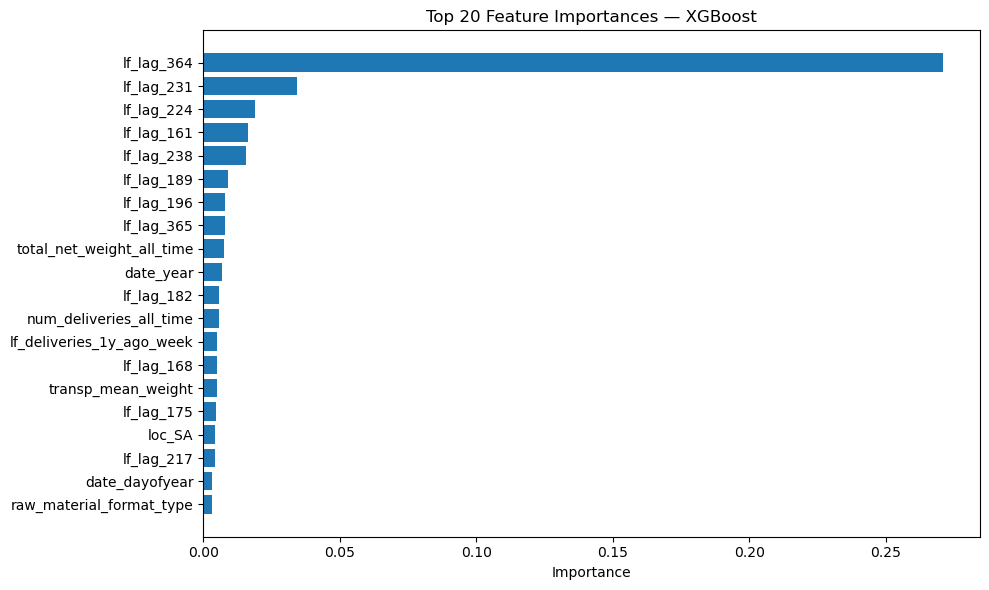

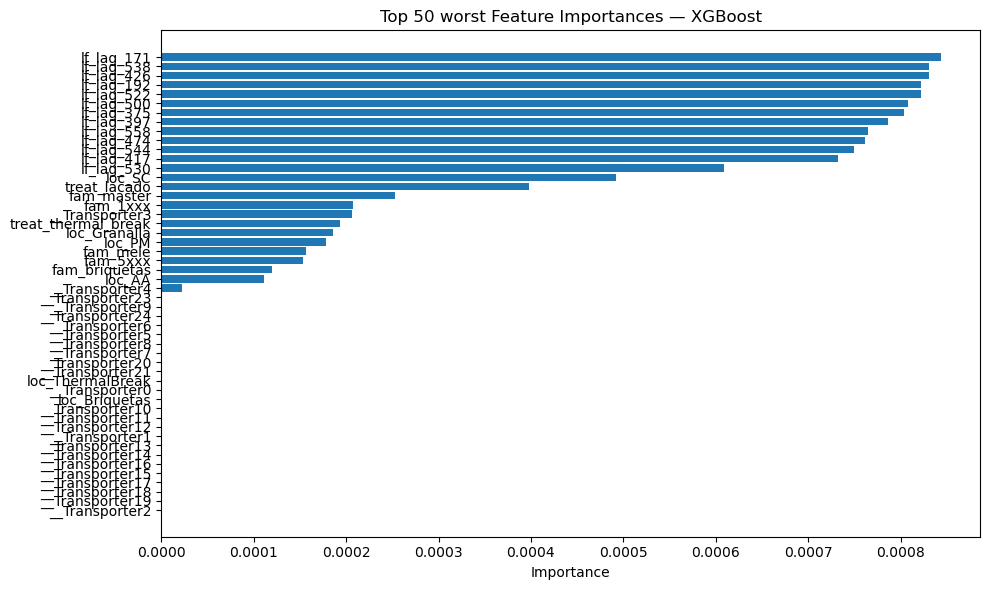

<BarContainer object of 471 artists>

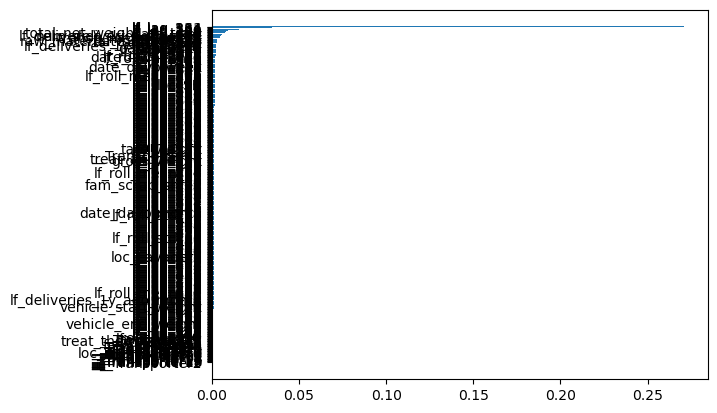

In [53]:
# plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][:20][::-1], feat_imp["importance"][:20][::-1])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances — XGBoost")
plt.tight_layout()
plt.show()

# plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp["feature"][::-1][:50], feat_imp["importance"][::-1][:50])
plt.xlabel("Importance")
plt.title("Top 50 worst Feature Importances — XGBoost")
plt.tight_layout()
plt.show()

plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])

In [55]:
data_for_forecast = df_all[df_all["date"]>=pd.Timestamp("2023-01-01")].copy()
cols_to_drop = [col for col in data_for_forecast.columns
                if col.startswith("lf_")] # => all lag features
data_for_forecast = data_for_forecast.drop(columns=cols_to_drop, errors="ignore")

forecast_range = pd.date_range(forecast_start, forecast_end, freq="D", name="date")

rm_ids = pd.Index(data_for_forecast["rm_id"].unique(), name="rm_id")
static_cols = [c for c in data_for_forecast.columns
                    if c not in {"date","net_weight"} and not c.startswith(("lf_","date_"))]
static_map = (
    data_for_forecast
      .drop_duplicates(subset=["rm_id"], keep="first")[[*static_cols]]
)


multi_index = pd.MultiIndex.from_product(
    [rm_ids, forecast_range],
    names=["rm_id", "date"]
)
# Create the base DataFrame
forecast_base_df = pd.DataFrame(index=multi_index).reset_index()
forecast_base_df=create_calendar_features(forecast_base_df,'date')
forecast_base_df = forecast_base_df.merge(static_map, on="rm_id", how="left")

# attach to the base grid

data_for_forecast = pd.concat([data_for_forecast, forecast_base_df])
data_for_forecast=data_for_forecast.sort_values(["rm_id","date"]).reset_index(drop=True)
data_for_forecast= create_lag_features(data_for_forecast,removeNA=False)
input_rows = data_for_forecast.loc[
    data_for_forecast['date'] >=forecast_start,
    columns_input
    ]


C:\Users\julie\AppData\Local\Temp\ipykernel_16800\641093796.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d["lf_deliveries_1y_ago_week"] = d.groupby("rm_id").apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_16800\641093796.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d["lf_deliveries_1y_ago_month"] = d.groupby("rm_id").apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_16800\641093796.py:31: FutureWa

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(input_rows.shape)

print(len(df_all["rm_id"].unique()))
print(len(receivals["rm_id"].unique()))

(485870, 471)
(485870,)
(70, 471)
(70,)
(10570, 471)
70
204


In [57]:
preds = model.predict(input_rows)

data_for_forecast.loc[
    data_for_forecast['date'] >= forecast_start, 'net_weight'
] = preds

if Positive_Deliveries:
    data_for_forecast["net_weight"] = data_for_forecast["net_weight"].clip(lower=0)

# assign value 0 for the weekend
if weekend0:
    data_for_forecast.loc[data_for_forecast['date_isweekend'] == True, 'net_weight'] = 0
#------------------------ Apply a coefficient to have smaller deliveries -----------------

if reduction_by_coefficient >0:
    data_for_forecast["net_weight"] = data_for_forecast["net_weight"] * reduction_by_coefficient

if clear_small_Deliveries:
    data_for_forecast.loc[data_for_forecast["net_weight"] < 500, "net_weight"] = 0
df_pred_2025 = data_for_forecast[data_for_forecast['date'] >= forecast_start]


In [58]:
def plot_history_vs_forecast(df_all, df_pred_2025, rm_id,start_date="2023-01-01"):
    # ensure types
    hist = df_all.loc[(df_all["rm_id"] == rm_id) & (df_all["date"] >= pd.Timestamp(start_date)), ["date", "net_weight"]].copy()
    pred = df_pred_2025.loc[df_pred_2025["rm_id"] == rm_id, ["date", "net_weight"]].copy()

    # plot
    plt.figure(figsize=(10, 5)) 
    plt.plot(hist["date"], hist["net_weight"], label="History")
    plt.plot(pred["date"], pred["net_weight"], label="Forecast")

    # reference line for forecast start (optional)
    fs = pd.Timestamp("2025-01-01")
    plt.axvline(fs, linestyle="--")

    plt.title(f"rm_id {rm_id} — net_weight: history vs forecast")
    plt.xlabel("Date")
    plt.ylabel("net_weight")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

rm_id to test :
2121. 2123. 2124. 2125. 2129. 2130. 2131. 2132. 2133. 2134. 2135. 2138.
 2140. 2142. 2143. 2144. 2145. 2147. 2153. 2160. 2161. 2284. 2401. 2402.
 2482. 2521. 2561. 2601. 2741. 2742. 2761. 2821. 2981. 3005. 3121. 3122.
 3123. 3124. 3125. 3126. 3142. 3161. 3162. 3201. 3241. 3265. 3282. 3362.
 3381. 3421. 3441. 3601. 3621. 3642. 3701. 3761. 3762. 3781. 3841. 3865.
 3883. 3901. 3941. 4021. 4081. 4222. 4263. 4302. 4441. 4443.

 2130.0, 4263.0, 4501.0 (last rm_id)
 


In [59]:

if False:
    for rm in data_for_forecast["rm_id"].unique():
        plot_history_vs_forecast(df_all, df_pred_2025, rm, start_date="2004-01-01")

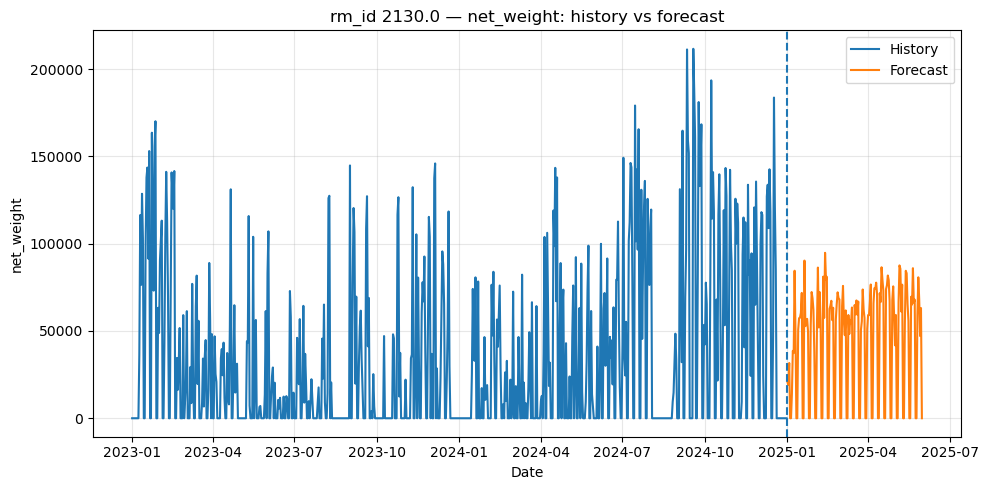

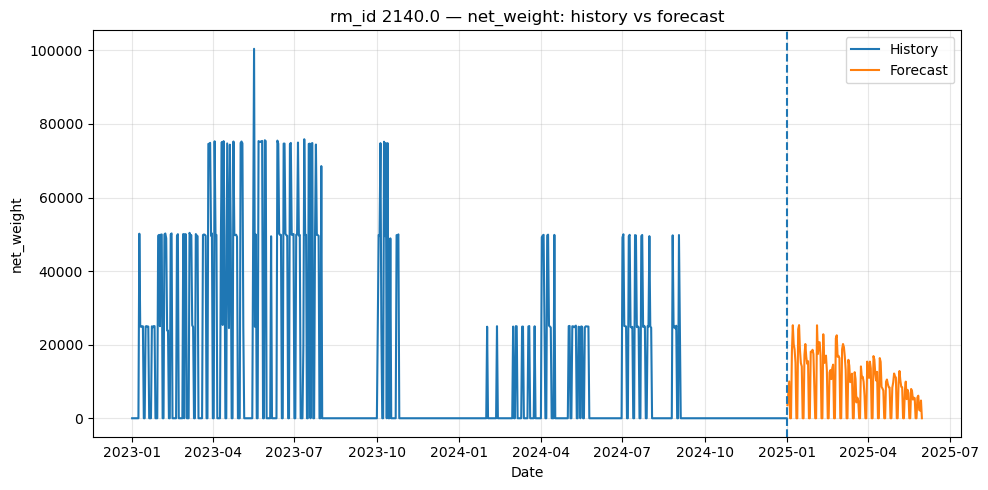

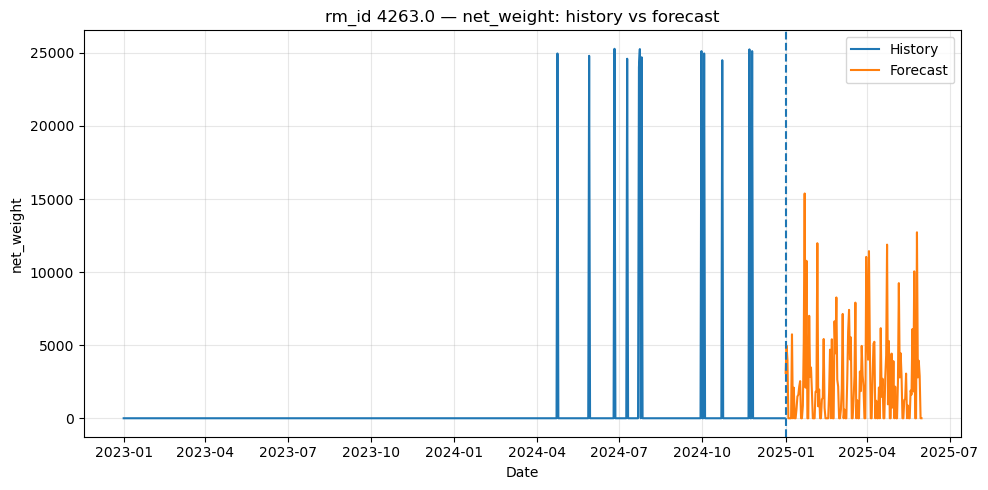

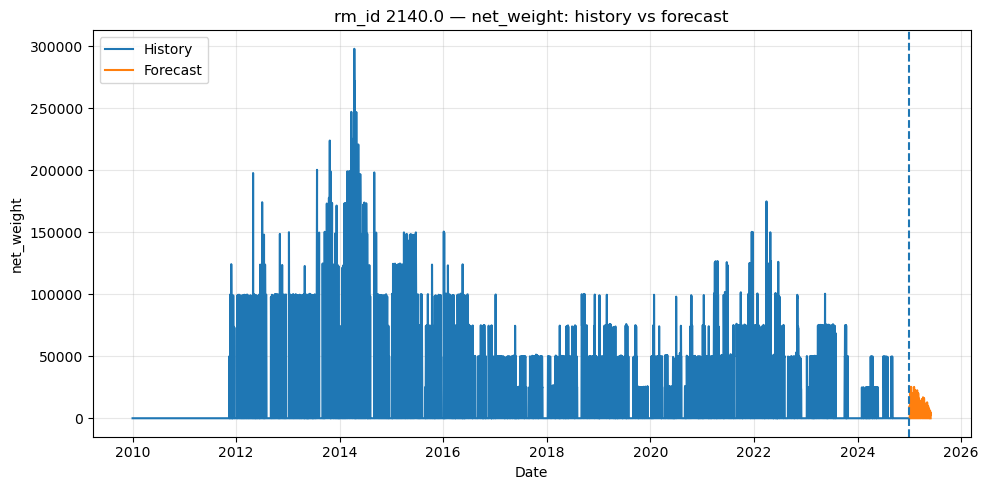

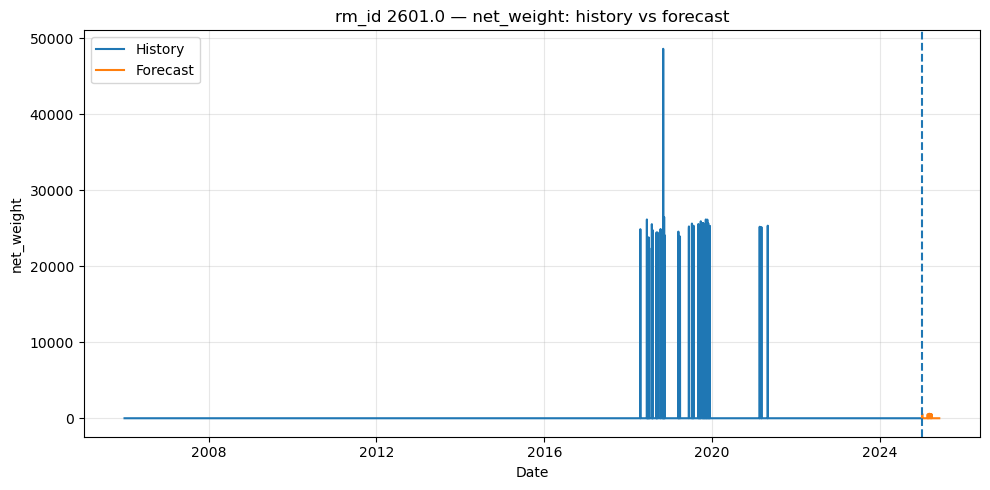

In [60]:
plot_history_vs_forecast(df_all, df_pred_2025, 2130.0)
plot_history_vs_forecast(df_all, df_pred_2025, 2140.0)
plot_history_vs_forecast(df_all, df_pred_2025, 4263.0)
plot_history_vs_forecast(df_all, df_pred_2025, 2140.0,start_date="2010-01-01")
plot_history_vs_forecast(df_all, df_pred_2025, 2601.0,start_date="2005-01-01")

# create a coefficient to have the best score.
idea : the score is asymetric so higher predicted net_weight is bad, I would like to find the best parameter p
such that p*pred give the best score

Steps:
Take the test set :
- predict weight
- calculate the cumsum
- for a certain range of alpha
-   - calculate the score
-   - find the argmin
stock the good value
-calculate 

In [ ]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(df_all, test_size=2024)
## the test set have to contain only 2024 data*

C:\Users\julie\AppData\Local\Temp\ipykernel_23384\3598047402.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = df_all.groupby('rm_id').apply(
C:\Users\julie\AppData\Local\Temp\ipykernel_23384\3598047402.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = df_all.groupby('rm_id').apply(


In [ ]:

test_pred=model.predict(X_test)


0       2024-01-01
1       2024-01-02
2       2024-01-03
3       2024-01-04
4       2024-01-05
           ...    
25615   2024-12-27
25616   2024-12-28
25617   2024-12-29
25618   2024-12-30
25619   2024-12-31
Name: date, Length: 25620, dtype: datetime64[ns]


NameError: name 'model' is not defined

In [65]:
#Fichier des predictions
df_pred_2025["net_weight"]=df_pred_2025["net_weight"]*0.7

df_final_cum  = (
    df_pred_2025.groupby("rm_id", as_index=False)
        .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))
        .reset_index(drop=True)
        [["rm_id", "date", "cum"]]
)


C:\Users\julie\AppData\Local\Temp\ipykernel_16800\3722856832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred_2025["net_weight"]=df_pred_2025["net_weight"]*0.7
C:\Users\julie\AppData\Local\Temp\ipykernel_16800\3722856832.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(cum=g["net_weight"].cumsum()))


In [64]:
print_submission(df_final_cum,filename="XGBoost.csv")

      ID  predicted_weight
2100   1               0.0
2101   2               0.0
2102   3               0.0
2103   4               0.0
2104   5               0.0
